Last words: 
    
I have managed to find a parameter set that lead to a simple True-False classifier lead buying function making profit - even though I couldn't achieve the same growth as the hand-built function. 

At the moment I'm satisfied with this, and at the end I discuss what directions would (or should I say will) I take to improve the project. After I finish polishing my other projects (and maybe tried myself in a few Kaggle competitions) I want to revisit this one. By then I'll have proper tournament data accumulated. 

In this notebook I intend to use the scikit-learn library to make automated trading decisions similarly to the previous notebook, except this time with no "direct control" over the decisions. I hope this would result in an increase in effectiveness and profits. 

I will compare the best approach from this notebook with the previously successful strategy. 

At first I would like to try two kinds of decision trees with different kinds of setups. 

The tree would be a classifier using the past 5 points (just to be fair to my previous assumptions) to answer a simple yes-or-no question: "will the price be higher than today in 5 days?". This  tree allows me to use the previous simplistic selling rule-set since the tree is either right or wrong, and we will find out in <=5 days...

For latter I should also try whether the tree needs to be trained for every worthy card or only the current card in question. The latter raises the problem of constant re-training (or keeping a huge bunch of trees alive), the former introduces one important and well-known bias with decision trees that emerges when different classes (And I have already shown that the cards can be put into classes depending on their behaviour) dominate the training set.

one could also argue for feeding an excessive amount of data - like a month's worth - as the input, and that could - in theory and after good training - use the early parts to classify the card for itself and once that is done use only the most recent points to make the prediction - based on the classification - but I don't think that this would worth the training nor that a decision tree would be an optimal approach here.

Hm... I don't think I have anything more to say to be honest, so let's start building something

In [173]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from glob2 import glob
from sklearn.tree import DecisionTreeClassifier

In [174]:
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.tree import export_text

In [175]:
univ_keys=['fair_price', 'isFoil', 'name', 'setName']#THis is probably unnecessary...

In [176]:
#load the data - fortunately I have already prepped the training data into one csv. - and estabilish the collection.
collection=[500, pd.DataFrame(columns=["name","isFoil", "Qtty", "Bought_price", "Current_price","Bought_date" ])] # this is the object that will get passed around by every function
#bought price is average - since that is what I need to exceed in order to sell with a profit...
#This was at the start, but from now I will run a different one
all_cards=pd.read_csv("past_data.csv")
all_cards.date=all_cards.date.astype('datetime64[D]')#this has to happen...

Now let's cut all_cards into proper training data. 
At first I'll make:
an instance of X=Data from the past 5 days+today (I know that my linear model had less to work with, but this is an advantage I'm willing to give the decision tree...) following each other.
Y = True or False (1 or 0) depending on whether the next 5 - edit: 2 makes the tree effective enough, though this shouldn't be a surprise - days have a value higher than the current.
I'd like to use the data before march 3rd as a training data (basically this means X will contain the data before Febr. 24th). In a more advanced model I'd "re-train" regularly (even if not daily, I would do it weekly/bi-weekly with the increased training pool).

At first I'll train the classifier with all the data from all the cards, since that is the easiest task: I'll have a single classifier to handle all the decisions passed in its way. This could in many ways be analogous to the previous hand-built classifier, but I expect it to have less arbitrary values. Edit: But then again, it didn't _really_ know what we were looking for...

In [177]:
#modified from notebook 3 not to have hard-coded 5 in it:
def fill_n_prev_days(current_day,card_name, card_foil, all_cards,n ):
 #   print(type(current_day))
    work_with=all_cards.loc[(all_cards.name==card_name) & (all_cards.isFoil==card_foil) & (all_cards.date<=current_day)]#though this last shouldn't be an issue
    date_list=list(pd.date_range(start=current_day, periods=n, freq="-1D"))#past n days - modified to include "today" as well
    #this above inclusion means that I need to concat the new day's data before the decision making and not as a last step - like in the previous notebook.
    date_list.reverse()#I want ascending order
    prices=[]
    for one_day in date_list:
        if (len(work_with.loc[work_with.date<=one_day, "fair_price"].values)==0):
            print(card_name+" has some issues")
        prices.append(work_with.loc[work_with.date<=one_day, "fair_price"].values[-1])#this appends the last available price to the day. So if on that day I don't have data, thats no issue.
    return [pd.to_datetime(date_list), prices]#works as intended

In [178]:
#exc=0
for card_name in all_cards.name.unique():
    for foil in all_cards[all_cards.name==card_name].isFoil.unique():
        if all_cards[(all_cards.name==card_name)&(all_cards.isFoil==foil)].fair_price.mean()<2:
      #      print(card_name+" "+str(foil) +" excluded")
            all_cards=all_cards[~((all_cards.name==card_name)&(all_cards.isFoil==foil))]#I'm getting better at this
        #    exc+=1

In [179]:
print(len(all_cards.name.unique()))#256 unique cards
all_cards.reset_index(drop=True, inplace=True)


256


In [9]:
X=[]#Training x
Y=[]#Training y
progress=0
#let's fill these bad boys
for card_name in all_cards.name.unique():#At first I'll train on the whole collection
    for card_foil in all_cards[all_cards.name==card_name].isFoil.unique():
        #I'll once again use the fact that the dates are ordered 
        pseu_df=all_cards[(all_cards.name==card_name)&(all_cards.isFoil==card_foil)].reset_index(drop=True)#This step is technically not needed, but I think this being transparent is worth more
        # than the small piece of memory used by holding on to a small dataframe.
        #generate days that can contribute:
        cont_days=pd.date_range(start=pseu_df.date[0], end=pseu_df.date.values[-1], freq="1D")[5:-6]#these are the days for which I can predict in the training datafor for_which_day in cont_days:
        for for_which_day in cont_days:
            _, before_prices=fill_n_prev_days(for_which_day, card_name, card_foil,all_cards, 5)#the dates are not needed for now
            _, after_prices=fill_n_prev_days(for_which_day+pd.Timedelta("5 days"), card_name, card_foil,all_cards, 5)#the dates are not needed for now
            #before_prices=before_prices
            X.append(before_prices[:-1]-before_prices[-1])#X is ready - fortunately I don't really need the "date" axis for this as these are one day apart each. 
            #This is a place for obvious improvement both in a sense that I could handle the missing values probably better 
            #and more data could be passed (e.g. a 0-6 value to mark the day of the week - I still suspect that is important
            #- or of course some number representing tournament data, maybe a classification of the card - based on the clustering of #02. )    
            mybool=(max(after_prices-before_prices[-1])>0)#I can sell for profit
            Y.append(mybool)
    progress+=1
    print(progress)#This is because it was slooooow

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256


Ok, this took a bit longer than it sohuld've (~5 mins). I recognise that it wasn't built with effectiveness in mind - in every instance I have 4 values that are identical to the previous but shifted. This could be resolved even just by using numpy's roll() or something similar. Point is, I wanted to save programming and not computing time when writing the above lines....



Now I have my X and Y. I'll train my classification tree. I won't use the whole data for training though, I want to split them into train-test instances just so I can see (and show) something indicating how good my tree is...

In [11]:
X=np.array(X)
Y=np.array(Y)


In [127]:
catch=pd.DataFrame(columns=["deep", "days", "score"])
for seed in range(50):
    for dt in range(2,8):
        for day in range(0,4):
            X_train, X_test, Y_train, Y_test = train_test_split(X[:,day:], Y, test_size=0.1, random_state=seed ) #No random state here, I run this bit for a couple of time to see how it changes
            classifier = DecisionTreeClassifier(random_state=42, max_depth=dt)#I will try different max depths here until I find a good one
            classifier.fit(X_train, Y_train)
            point=classifier.score(X_test, Y_test)
            catch=catch.append(pd.DataFrame({"deep": [dt],
                              "days": [day],
                               "score" : [point]}), ignore_index=True)


Text(0, 0.5, 'Mean accuracy')

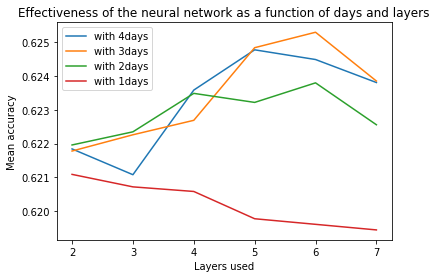

In [142]:
for i in catch.days.unique():
    used_layers=[]
    score=[]
    for j in catch.deep.unique():
        used_layers.append(j)
        score.append(catch[(catch.days==i) & (catch.deep==j)].score.mean())
    plt.plot(used_layers, score, label="with "+str(4-i) +"days" )
plt.legend()
plt.title("Effectiveness of the neural network as a function of days and layers")
plt.xlabel("Layers used")
plt.ylabel("Mean accuracy")

This was a bit ad-hoc, but now I can tell a few things. 

First, it seems that the classifier does overfit a bit as the results fluctuate, but for the overwhelming majority of random states I can conclude that the best result comes from when the classifier gets only the past 3 days of data, and uses 6 layers (This is not just a feature of the randomness, I have seen several - fixed - random states that lead to the same conclusion, but seeing the bigger picture of course reinforces this.)

In [30]:
(X[:,1:]).shape # This is the optimal shape

(41093, 3)

In [143]:
X=X[:,1:]

In [144]:

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)#42... obviously 


In [145]:
classifier = DecisionTreeClassifier(random_state=42, max_depth=6)#I will try different max depths here until I find a good one
classifier.fit(X_train, Y_train)
classifier.score(X_test, Y_test)

0.6367396593673966

In [147]:
#print(export_text(classifier)) #I don't think I need this output

This is not a great score... But a start.

Time to define the previous functions again (of course with modifications where necessary).

First of all, selling will still be controlled by the same selling alg.  - even though I could use the same decision tree to sell ("If False, sell") but that might skew the comparison, so maybe in a later stage...

This would also raise the problem that for each and every card I would either sell or buy every day (effectively eliminating the "I can't predict, just don't do anything with this card" option that should be the overwhelming majority, but that's just in the nature of DT classifiers...) 

In [148]:
all_cards.date.max()

Timestamp('2020-03-02 00:00:00')

In [168]:
def sell_card(prev, dates, new_price, today, bought_price, bought_date ):
    my_bool=False#The greenlight for selling
    if bought_price>new_price:#loss_cutting
        my_bool=cut_losses(prev, dates, new_price, today, bought_price, bought_date)
    elif bought_price<new_price:#Already gained.
        my_bool=sell_gain(prev, dates, new_price, today, bought_price, bought_date)
    else:#Might've bought a card that won't change for whatever reason... 
        my_bool=cut_losses(prev, dates, new_price, today, bought_price, bought_date)#I swapped this out, I don't think I wan tthe linear model anymore
    return my_bool

#These are the most simplistic functions - when I control the buys, and sell immediately when I think it is worth it... or when I've held onto the card for too long
def cut_losses(prev, dates, new_price, today, bought_price, bought_date):
    #first, If the card is bought very recently, I don't think there is a reason to panic
 #   print(type(today))
  #  print(type(bought_date))
    if (today-bought_date).days<5:
        return False
    else:
        return True#the rest is not needed
      
        
    
    
def sell_gain(prev, dates, new_price, today, bought_price, bought_date):#This comes into play when I already gained value on the card, but might expect to gain more? 
    return True#This as well

    
    
   


Now these will be modified a little bit: The buying decision is driven by the tree and the concatenation of today and past data should happen at the start not the end.

In [191]:
#the functions needed for a day. Now I only need the "frame" that calls them

def gather_new_day(date):#read all the data for a new day and append it to the rest. Inspired by the data cleaning segment
    new_data=glob("CSV/*"+str(date.date())+"*csv")
    my_obj=pd.DataFrame()
    #So... for every day I want to keep only the latest update with that date. (they should be more or less identical in a perfect world,
    #but on the off chance that the later one was started manually after a correction - this have happened - I will use the later one.)
    latest={}
    for item in new_data:#so the idea is that the later timestamp comes later in the list... so this way only the latest will be kept
        latest[item.split("_")[0]]=item
    new_data=list(latest.values())
    #now I can start reading
    for sheet in new_data:
        cards=pd.read_csv(sheet)
        cards=cards[univ_keys]
        my_obj=pd.concat([my_obj, cards])
    my_obj["date"]=pd.Timestamp(date.date())
    return my_obj.reset_index(drop=True)#works as intended
    print("The data gathering phase have ended")

def fill_5_prev_days(current_day,card_name, card_foil, all_cards ):
 #   print(type(current_day))
    work_with=all_cards.loc[(all_cards.name==card_name) & (all_cards.isFoil==card_foil) & (all_cards.date<current_day)]#though this last shouldn't be an issue
    date_list=list(pd.date_range(start=current_day, periods=6, freq="-1D")[1:])#past 5 days
    date_list.reverse()#I want ascending order
    prices=[]
    for one_day in date_list:
        if (len(work_with.loc[work_with.date<=one_day, "fair_price"].values)==0):
            print(card_name+" has some issues")
        prices.append(work_with.loc[work_with.date<=one_day, "fair_price"].values[-1])#this appends the last available price to the day. So if on that day I don't have data, thats no issue.
    return [date_list, prices]#works as intended
#I'm keeping this function for consistency's sake

def sell_cards(all_cards, todays_prices, collection):#no modifications needed here
    for idx, row in collection[1].iterrows():
        card_now=row["name"]
        bought_for=row.Bought_price
        bought_when=row.Bought_date
        foil=row.isFoil
        current_price=todays_prices.loc[(todays_prices["name"]==card_now)&(todays_prices.isFoil==foil),"fair_price" ].values[0]
        days, prices=fill_5_prev_days(pd.Timestamp(todays_prices.date[0]), card_now, foil, all_cards)#example.date[0] is the current day - basically for the whole "example" thing it is the current day so....
        days=pd.to_datetime(days)
        todays_date=pd.Timestamp(todays_prices.date[0])
        sell=sell_card(prices, days, current_price,todays_date, bought_for, bought_when)
        if sell: #then sell the card! get the money, remove the card. Here I would say that with this simplistic model if I sell a card, I sell ALL instances of said card.
            collection[0]+=current_price*collection[1].loc[(collection[1]["name"]==card_now)&(collection[1]["isFoil"]==foil), "Qtty"].values[0]
            collection[1].drop(idx, axis=0, inplace=True)#I can sell cards now!! 
        else:
            collection[1].at[idx, "Current_price"]=current_price#Update for analytics reasons.
    print("The selling phase have ended")

def buy_cards(all_cards, todays_date, collection, predictor_tree, data_depth):#After selling the collection, now let's buy cards! as a rule, I can only buy ONE instance of each card a day...
    possible_buys=all_cards[(all_cards.date==todays_date)& (all_cards["fair_price"]>7)]#Now I'll use the green line (as of in notebook #2) at first. The red line would increase the amount of available cards to ~3 times the current (100-120 cards to 300-360)
    #But I really don't intend to trade with very cheap cards - the assumption that I get them immediately AND the associated costs are negligible doesn't stand there anymore.
    #possible_buys=example[(example.name=="Spawn of Mayhem") & (example.isFoil==True)]
    for idx, row in possible_buys.iterrows():
        card_now=row["name"]
        foil=row.isFoil
        current_price=row.fair_price
        buy_this=False
        if len(all_cards.loc[(all_cards["name"]==card_now)&(all_cards.isFoil==foil)])>5:#basically if the set is too new (no data), then don't bother...
            days, prices=fill_n_prev_days(pd.Timestamp(todays_date), card_now, foil, all_cards,6)#example.date[0] is the current day - basically for the whole "example" thing it is the current day so....
            days=pd.to_datetime(days)
            prices=np.array(prices[:-1]-prices[-1])
            prices=prices[-1*data_depth:].reshape((1,-1))#As I have seen this as the best predictor
            buy_this=predictor_tree.predict(prices)[0]
        if buy_this:#This part should not be touched... just the decision was changed.
            if collection[0]>= current_price:
                collection[0]-=current_price#Buy one piece
                if len(collection[1].loc[(collection[1]["name"]==card_now)&(collection[1].isFoil==foil), "Qtty"])==0:#I don't have this card in the collection
                    ex_buy=pd.DataFrame({"name": [card_now],
                                         "Qtty": [1],
                                          "isFoil": [foil],
                                          "Bought_price": [current_price],
                                         "Current_price": [current_price],
                                        "Bought_date": [pd.Timestamp(todays_date)]
                                         })
                    collection[1]=pd.concat([collection[1], ex_buy], sort=False)
                    collection[1].reset_index(drop=True, inplace=True)
                else:#I already have at least 1 in my collection oh the price update is ugly, the others are managable...
                    collection[1].loc[(collection[1]["name"]==card_now)&(collection[1].isFoil==foil), "Bought_price"]=(collection[1].loc[(collection[1]["name"]==card_now)&(collection[1].isFoil==foil), "Bought_price"]*collection[1].loc[(collection[1]["name"]==card_now)&(collection[1].isFoil==foil), "Qtty"]+current_price)/(collection[1].loc[(collection[1]["name"]==card_now)&(collection[1].isFoil==foil), "Qtty"]+1)
                    collection[1].loc[(collection[1]["name"]==card_now)&(collection[1].isFoil==foil), "Bought_date"]=pd.Timestamp(todays_date).date()#This is the newest buy of this card
                    collection[1].loc[(collection[1]["name"]==card_now)&(collection[1].isFoil==foil), "Qtty"]+=1
            else:
                print(card_now + " Can't be bought because I have no funds")
    print("The buying phase have ended") #and works as intended though it buys a bit extensively - I hope this will not become an issue
    
def print_gain_or_loss(total):
    if total>=500:
        return str(round(total-500, 2))+"$ have been gained"
    elif total<500:
        return str(round(500-total, 2))+"$ have been lost"#...
    
def evaluate_the_day(todays_date, collection):
    f=open("sum_the_strat.csv", "a")
    money=collection[0]
    foil_cards=collection[1].loc[collection[1].isFoil, "Qtty"].sum()
    non_foils=collection[1].loc[~(collection[1].isFoil.astype(bool)), "Qtty"].sum()#that astype is needed here so I can negate...
    card_values=(collection[1]["Qtty"]*collection[1]["Current_price"]).sum()
    print("On "+str(todays_date.date()) +" the algorithm has " +str(round(money,2))+"$ at its disposal, and " +str(round(card_values,2))+"$ in card values of " +str(foil_cards+non_foils) +" cards. \n This means that the total value is "+str(round(money+card_values, 2)) +"$ and "+print_gain_or_loss(money+card_values) )#though I could format with f-string formatting, I'm just not used to that yet... (I still have a few habits from py2)
    f.write(str(todays_date)+";"+str(money)+";"+str(card_values)+";"+str(foil_cards)+";"+str(non_foils)+"\n")
    collection[1].to_csv("states_of_collection/"+str(todays_date.date()).replace("-", "_")+"_coll.csv", index=False)#works as intended - though it would be hard to mess up
    
def one_day(date, all_cards, collection, predictor_tree, data_depth):#
    current_card_prices=gather_new_day(date)
    all_cards=pd.concat([all_cards, current_card_prices])
    all_cards.reset_index(drop=True, inplace=True)#reset indexes though I suspect this might happen later as well
    if len(current_card_prices.index)==0:
        print("No data for "+str(date))
        return all_cards
    sell_cards(all_cards,current_card_prices,collection)
    buy_cards(all_cards,date,collection, predictor_tree, data_depth)
    evaluate_the_day(date, collection)
    print("Day_over")
    all_cards.to_csv("all_cards_current.csv", index=False)#Just in case
    return all_cards#So it basically runs: "all_cards=one_day(date, all_cards, collection)    

In [169]:
test_run=pd.date_range("2020-03-03", "2020-05-15")
collection=[500, pd.DataFrame(columns=["name","isFoil", "Qtty", "Bought_price", "Current_price","Bought_date" ])] # this is the object that will get passed around by every function
#bought price is average - since that is what I need to exceed in order to sell with a profit...
#This was at the start, but from now I will run a different one
all_cards=pd.read_csv("past_data.csv")
all_cards.date=all_cards.date.astype('datetime64[D]')#this has to happen...
#rules_to_buy=[spiked_down, raising_value]


In [ ]:
for a_day in test_run:
    all_cards=one_day(a_day, all_cards, collection, classifier)

I had to shut this down. 
The tree buys too aggressively (it lives the funds up in 2 days) and then the value fluctuates around +/- 20$. This tree seems incapable of making profit. 
I would have to make either the Y target more decisive (those 5 days are way too vague it seems) or find a better metric or output. 


In [180]:
X=[]#Training x
Y=[]#Training y
progress=0
#let's fill these bad boys
for card_name in all_cards.name.unique():#At first I'll train on the whole collection
    for card_foil in all_cards[all_cards.name==card_name].isFoil.unique():
        #I'll once again use the fact that the dates are ordered 
        pseu_df=all_cards[(all_cards.name==card_name)&(all_cards.isFoil==card_foil)].reset_index(drop=True)#This step is technically not needed, but I think this being transparent is worth more
        # than the small piece of memory used by holding on to a small dataframe.
        #generate days that can contribute:
        cont_days=pd.date_range(start=pseu_df.date[0], end=pseu_df.date.values[-1], freq="1D")[5:-6]#these are the days for which I can predict in the training datafor for_which_day in cont_days:
        for for_which_day in cont_days:
            _, before_prices=fill_n_prev_days(for_which_day, card_name, card_foil,all_cards, 6)#the dates are not needed for now
            _, after_prices=fill_n_prev_days(for_which_day+pd.Timedelta("2 days"), card_name, card_foil,all_cards, 2)#the dates are not needed for now
            #I know this includes the current day but that day won't contribute to a 'True' value so...
            #before_prices=before_prices#I... have no clue what I wanted here
            X.append(before_prices[:-1]-before_prices[-1])#X is ready - fortunately I don't really need the "date" axis for this as these are one day apart each. 
            #This is a place for obvious improvement both in a sense that I could handle the missing values probably better 
            #and more data could be passed (e.g. a 0-6 value to mark the day of the week - I still suspect that is important
            #- or of course some number representing tournament data, maybe a classification of the card - based on the clustering of #02. )    
            mybool=(max(after_prices-before_prices[-1])>0)#I can sell for profit
            Y.append(mybool)
    progress+=1
    print(progress)#This is because it was slooooow

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256


In [187]:
X=np.array(X)
Y=np.array(Y)


In [188]:
catch=pd.DataFrame(columns=["deep", "days", "score"])
for seed in range(50):
    for dt in range(2,8):
        for day in range(0,4):
            X_train, X_test, Y_train, Y_test = train_test_split(X[:,day:], Y, test_size=0.1, random_state=seed ) #No fixed random state here, I run this bit for a couple of time to see how it changes
            classifier = DecisionTreeClassifier(random_state=42, max_depth=dt)#I will try different max depths here until I find a good one
            classifier.fit(X_train, Y_train)
            point=classifier.score(X_test, Y_test)
            catch=catch.append(pd.DataFrame({"deep": [dt],
                              "days": [day],
                               "score" : [point]}), ignore_index=True)


Text(0, 0.5, 'Mean accuracy')

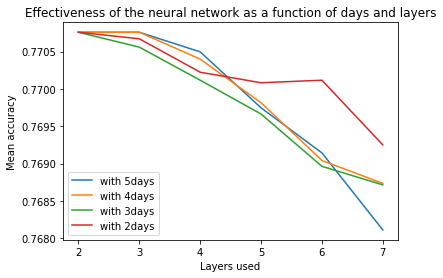

In [189]:
for i in catch.days.unique():
    used_layers=[]
    score=[]
    for j in catch.deep.unique():
        used_layers.append(j)
        score.append(catch[(catch.days==i) & (catch.deep==j)].score.mean())
    plt.plot(used_layers, score, label="with "+str(5-i) +"days" )
plt.legend()
plt.title("Effectiveness of the neural network as a function of days and layers")
plt.xlabel("Layers used")
plt.ylabel("Mean accuracy")

This is interesting.
By the looks of it more than 2-3 layers tend to overfit for the data (but to be fair, my own functions could be represented as decision trees of about the same depth). I will disregard the 2 days tree (even if with 6+ layers that was the most accurate, that is likely because the others did overfit way too much) and go with the 4 days (orange) since that seems to be my best bet with 3 layers.

In [195]:
test_run=pd.date_range("2020-03-03", "2020-05-15")
collection=[500, pd.DataFrame(columns=["name","isFoil", "Qtty", "Bought_price", "Current_price","Bought_date" ])] # this is the object that will get passed around by every function
#bought price is average - since that is what I need to exceed in order to sell with a profit...
#This was at the start, but from now I will run a different one
all_cards=pd.read_csv("past_data.csv")
all_cards.date=all_cards.date.astype('datetime64[D]')#this has to happen...
#rules_to_buy=[spiked_down, raising_value]


In [197]:
X_train, X_test, Y_train, Y_test = train_test_split(X[:,-4:], Y, test_size=0.1, random_state=42 ) #tbh I don't think this is needed
classifier = DecisionTreeClassifier(random_state=42, max_depth=6)#I will try different max depths here until I find a good one
classifier.fit(X[:,-4:], Y)#I'll use the whole sample this time, no point in removing 1/10th of it...
#classifier.score(X_test, Y_test)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [198]:
for a_day in test_run:
    all_cards=one_day(a_day, all_cards, collection, classifier, 4)

The selling phase have ended
The buying phase have ended
On 2020-03-03 the algorithm has 453.11$ at its disposal, and 46.89$ in card values of 2 cards. 
 This means that the total value is 500.0$ and 0.0$ have been gained
Day_over
The selling phase have ended
The buying phase have ended
On 2020-03-04 the algorithm has 453.11$ at its disposal, and 46.89$ in card values of 2 cards. 
 This means that the total value is 500.0$ and 0.0$ have been gained
Day_over
The selling phase have ended
The buying phase have ended
On 2020-03-05 the algorithm has 481.11$ at its disposal, and 20.49$ in card values of 2 cards. 
 This means that the total value is 501.6$ and 1.6$ have been gained
Day_over
The selling phase have ended
The buying phase have ended
On 2020-03-06 the algorithm has 462.08$ at its disposal, and 39.5$ in card values of 3 cards. 
 This means that the total value is 501.58$ and 1.58$ have been gained
Day_over
The selling phase have ended
The buying phase have ended
On 2020-03-07 the 

The selling phase have ended
The buying phase have ended
On 2020-04-07 the algorithm has 411.05$ at its disposal, and 111.75$ in card values of 8 cards. 
 This means that the total value is 522.8$ and 22.8$ have been gained
Day_over
The selling phase have ended
The buying phase have ended
On 2020-04-08 the algorithm has 398.61$ at its disposal, and 124.65$ in card values of 7 cards. 
 This means that the total value is 523.26$ and 23.26$ have been gained
Day_over
The selling phase have ended
The buying phase have ended
On 2020-04-09 the algorithm has 443.06$ at its disposal, and 83.76$ in card values of 5 cards. 
 This means that the total value is 526.82$ and 26.82$ have been gained
Day_over
The selling phase have ended
The buying phase have ended
On 2020-04-10 the algorithm has 321.9$ at its disposal, and 193.03$ in card values of 8 cards. 
 This means that the total value is 514.93$ and 14.93$ have been gained
Day_over
The selling phase have ended
The buying phase have ended
On 2020

c:\users\domenyb\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:106: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



No data for 2020-04-16 00:00:00
The selling phase have ended
The buying phase have ended
On 2020-04-17 the algorithm has 552.74$ at its disposal, and 11.99$ in card values of 1 cards. 
 This means that the total value is 564.73$ and 64.73$ have been gained
Day_over


c:\users\domenyb\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:106: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



The selling phase have ended
The buying phase have ended
On 2020-04-18 the algorithm has 552.83$ at its disposal, and 12.57$ in card values of 1 cards. 
 This means that the total value is 565.4$ and 65.4$ have been gained
Day_over


c:\users\domenyb\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:106: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



The selling phase have ended
The buying phase have ended
On 2020-04-19 the algorithm has 552.83$ at its disposal, and 12.57$ in card values of 1 cards. 
 This means that the total value is 565.4$ and 65.4$ have been gained
Day_over


c:\users\domenyb\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:106: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



The selling phase have ended
The buying phase have ended
On 2020-04-20 the algorithm has 505.89$ at its disposal, and 59.51$ in card values of 2 cards. 
 This means that the total value is 565.4$ and 65.4$ have been gained
Day_over


c:\users\domenyb\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:106: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



The selling phase have ended
The buying phase have ended
On 2020-04-21 the algorithm has 505.89$ at its disposal, and 59.51$ in card values of 2 cards. 
 This means that the total value is 565.4$ and 65.4$ have been gained
Day_over


c:\users\domenyb\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:106: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



The selling phase have ended
The buying phase have ended
On 2020-04-22 the algorithm has 505.89$ at its disposal, and 59.51$ in card values of 2 cards. 
 This means that the total value is 565.4$ and 65.4$ have been gained
Day_over


c:\users\domenyb\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:106: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



The selling phase have ended
The buying phase have ended
On 2020-04-23 the algorithm has 518.46$ at its disposal, and 46.94$ in card values of 1 cards. 
 This means that the total value is 565.4$ and 65.4$ have been gained
Day_over


c:\users\domenyb\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:106: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



The selling phase have ended
The buying phase have ended
On 2020-04-24 the algorithm has 518.46$ at its disposal, and 46.94$ in card values of 1 cards. 
 This means that the total value is 565.4$ and 65.4$ have been gained
Day_over


c:\users\domenyb\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:106: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



The selling phase have ended
The buying phase have ended
On 2020-04-25 the algorithm has 565.4$ at its disposal, and 0$ in card values of 0 cards. 
 This means that the total value is 565.4$ and 65.4$ have been gained
Day_over


c:\users\domenyb\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:106: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



The selling phase have ended
The buying phase have ended
On 2020-04-26 the algorithm has 533.41$ at its disposal, and 31.99$ in card values of 1 cards. 
 This means that the total value is 565.4$ and 65.4$ have been gained
Day_over


c:\users\domenyb\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:106: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



The selling phase have ended
The buying phase have ended
On 2020-04-27 the algorithm has 519.16$ at its disposal, and 46.24$ in card values of 2 cards. 
 This means that the total value is 565.4$ and 65.4$ have been gained
Day_over


c:\users\domenyb\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:106: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



The selling phase have ended
The buying phase have ended
On 2020-04-28 the algorithm has 500.76$ at its disposal, and 64.75$ in card values of 2 cards. 
 This means that the total value is 565.51$ and 65.51$ have been gained
Day_over


c:\users\domenyb\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:106: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



The selling phase have ended
The buying phase have ended
On 2020-04-29 the algorithm has 427.33$ at its disposal, and 138.17$ in card values of 6 cards. 
 This means that the total value is 565.5$ and 65.5$ have been gained
Day_over


c:\users\domenyb\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:106: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



The selling phase have ended
The buying phase have ended
On 2020-04-30 the algorithm has 394.33$ at its disposal, and 171.17$ in card values of 7 cards. 
 This means that the total value is 565.5$ and 65.5$ have been gained
Day_over


c:\users\domenyb\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:106: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



The selling phase have ended
The buying phase have ended
On 2020-05-01 the algorithm has 533.27$ at its disposal, and 36.31$ in card values of 2 cards. 
 This means that the total value is 569.58$ and 69.58$ have been gained
Day_over


c:\users\domenyb\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:106: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



The selling phase have ended
The buying phase have ended
On 2020-05-02 the algorithm has 533.27$ at its disposal, and 36.31$ in card values of 2 cards. 
 This means that the total value is 569.58$ and 69.58$ have been gained
Day_over


c:\users\domenyb\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:106: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



The selling phase have ended
The buying phase have ended
On 2020-05-03 the algorithm has 439.19$ at its disposal, and 132.01$ in card values of 6 cards. 
 This means that the total value is 571.2$ and 71.2$ have been gained
Day_over


c:\users\domenyb\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:106: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



The selling phase have ended
The buying phase have ended
On 2020-05-04 the algorithm has 453.84$ at its disposal, and 117.36$ in card values of 5 cards. 
 This means that the total value is 571.2$ and 71.2$ have been gained
Day_over


c:\users\domenyb\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:106: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



The selling phase have ended
The buying phase have ended
On 2020-05-05 the algorithm has 250.83$ at its disposal, and 318.78$ in card values of 5 cards. 
 This means that the total value is 569.61$ and 69.61$ have been gained
Day_over


c:\users\domenyb\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:106: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



The selling phase have ended
The buying phase have ended
On 2020-05-06 the algorithm has 28.83$ at its disposal, and 540.78$ in card values of 6 cards. 
 This means that the total value is 569.61$ and 69.61$ have been gained
Day_over


c:\users\domenyb\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:106: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



The selling phase have ended
Nyxbloom Ancient (Extended Art) Can't be bought because I have no funds
Uro, Titan of Nature's Wrath (Extended Art) Can't be bought because I have no funds
The buying phase have ended
On 2020-05-07 the algorithm has 23.81$ at its disposal, and 452.01$ in card values of 8 cards. 
 This means that the total value is 475.82$ and 24.18$ have been lost
Day_over


c:\users\domenyb\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:106: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



The selling phase have ended
The buying phase have ended
On 2020-05-08 the algorithm has 45.59$ at its disposal, and 535.81$ in card values of 7 cards. 
 This means that the total value is 581.4$ and 81.4$ have been gained
Day_over


c:\users\domenyb\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:106: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



The selling phase have ended
The buying phase have ended
On 2020-05-09 the algorithm has 45.59$ at its disposal, and 535.81$ in card values of 7 cards. 
 This means that the total value is 581.4$ and 81.4$ have been gained
Day_over


c:\users\domenyb\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:106: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



The selling phase have ended
Uro, Titan of Nature's Wrath Can't be bought because I have no funds
The buying phase have ended
On 2020-05-10 the algorithm has 34.0$ at its disposal, and 552.69$ in card values of 7 cards. 
 This means that the total value is 586.69$ and 86.69$ have been gained
Day_over


c:\users\domenyb\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:106: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



The selling phase have ended
The buying phase have ended
On 2020-05-11 the algorithm has 499.52$ at its disposal, and 91.54$ in card values of 3 cards. 
 This means that the total value is 591.06$ and 91.06$ have been gained
Day_over


c:\users\domenyb\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:106: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



The selling phase have ended
The buying phase have ended
On 2020-05-12 the algorithm has 468.69$ at its disposal, and 122.37$ in card values of 4 cards. 
 This means that the total value is 591.06$ and 91.06$ have been gained
Day_over


c:\users\domenyb\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:106: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



The selling phase have ended
The buying phase have ended
On 2020-05-13 the algorithm has 243.17$ at its disposal, and 351.09$ in card values of 7 cards. 
 This means that the total value is 594.26$ and 94.26$ have been gained
Day_over


c:\users\domenyb\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:106: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



The selling phase have ended
The buying phase have ended
On 2020-05-14 the algorithm has 48.18$ at its disposal, and 546.08$ in card values of 8 cards. 
 This means that the total value is 594.26$ and 94.26$ have been gained
Day_over


c:\users\domenyb\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:106: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



The selling phase have ended
Uro, Titan of Nature's Wrath (Extended Art) Can't be bought because I have no funds
The buying phase have ended
On 2020-05-15 the algorithm has 20.14$ at its disposal, and 574.71$ in card values of 9 cards. 
 This means that the total value is 594.85$ and 94.85$ have been gained
Day_over


In [199]:
simple_sell=pd.read_csv("buy_upspike_sell_simple.csv", sep=";", names=["date", "money_available", "money_in_cards", "#foils", "#nonfoils"])
simple_sell.date=simple_sell.date.astype('datetime64[D]')
class_tree_buy=pd.read_csv("Classifier_tree_buy.csv", sep=";", names=["date", "money_available", "money_in_cards", "#foils", "#nonfoils"])
class_tree_buy.date=simple_sell.date.astype('datetime64[D]')

Text(0.5, 1.0, 'Comparison of the manually and the ML-built decision makers. \n Solid line is the previous buyer, dashed line is the Sklearn tree ')

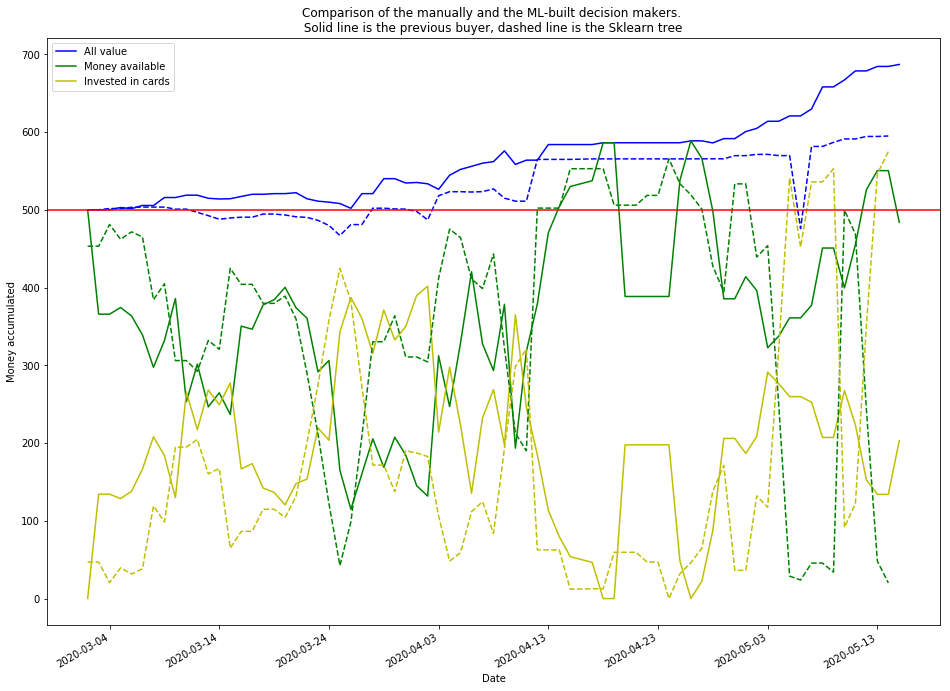

In [202]:
plt.figure(figsize=(16,12))

plt.plot(simple_sell.date, simple_sell.money_available+simple_sell.money_in_cards, "b-", label="All value")
plt.plot(simple_sell.date, simple_sell.money_available, "g-", label="Money available")
plt.plot(simple_sell.date, simple_sell.money_in_cards, "y-", label="Invested in cards")
plt.plot(class_tree_buy.date, class_tree_buy.money_available+class_tree_buy.money_in_cards, "b--", label="_nolegend_")
plt.plot(class_tree_buy.date, class_tree_buy.money_available, "g--", label="_nolegend_")
plt.plot(class_tree_buy.date, class_tree_buy.money_in_cards, "y--", label="_nolegend_")
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate()
x,y=plt.xlim()
plt.plot([x-1, y+1], [500,500], "r-", label="_nolegend_")
plt.xlim(x,y)
plt.xlabel("Date")
plt.ylabel("Money accumulated")
plt.title ("Comparison of the manually and the ML-built decision makers. \n Solid line is the previous buyer, dashed line is the Sklearn tree ")

So... While many features tend to be the same - This suggests that the decision tree managed to "catch on" to the same or similar pattern I wanted to capture - the decision tree seems to be a somewhat "shy" buyer - which is a strong contrast with the previous too aggressive behaviour. 

As for the future of this project: 

I think the project itself has great potential in it - especially now with gathering tournament data as well -, and of course there is plenty of room for improvement, including but not limited to:
    - the selling function was not really explored, it has a very simplistic form even at the time of writing this.
    - even for the buying part I more or less just used the data in its raw form, without implementing any meaningful metrics or even weighing the data.
    - Using ADX could probably catch the trends that have proven to be elusive to the simplistic buying function.
    - More complicated models could be implemented and tried (LSTM, or some other kind...)
    - I have not managed to catch clues regarding inside information - despite this year being the most ban-heavy year of MTG ever. But maybe more refined data could do something with it.
    
For the above reasons I will not shut the gathering down at the moment, and plan to revisit this project sooner rather than later. But for now I don't think that the time put into this would "repay itself" as other projects need my time to be cleaned up and polished, so this is what I have card-tradingwise for now. 